## Portfolio Management
Fund managers managing portfolio needs to optimise their allocations of resources to different classes of assets to meet risk-reward objectives set out by the funds.


## Project Objectives
- In this exercise, I will code the algorithm to plot the efficiency frontier of a portfolio of stocks within the equity asset class.

- This will be of interest to fund managers who needs to regularly rebalance their fund allocations to meets the objectives of their funds.

- We will also be looking at how the efficiency frontier has shifted from the pre-Covid period.

## Assumptions
I am assuming a scenario where a fund manager is regularly monitoring the performance of the fund and will use the efficiency frontier as one of the matrices to measure the fund performance and update the fund allocation when necessary.

The fund currently holds the following stocks: FB, AAPL, AMZN, IBM, GOOGL, MSFT, NVDA, O, QCOM, TSLA.

## Related Work
Ideas and inspirations were taken from the followings:
- Portfolio optimization (https://en.wikipedia.org/wiki/Portfolio_optimization)
- Modern Portfolio Theory (https://www.investopedia.com/terms/m/modernportfoliotheory.asp)


In [1]:
## Import some useful libraries
import pandas as pd
import numpy as np
import requests
import json
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

## Data
Stock data are taken from RapidAPI Hub (www.rapidapi.com) and Alpha Vantage (https://rapidapi.com/alphavantage/api/alpha-vantage/)

In [2]:
# define a function to download stock data from provider
# data retrieved from Alpha Vantage but AV have only "compact" and "full" mode for range of dates.
# "compact" gives 100 data points while "full" gives 20+ years of data
# output to a txt file

# stocks = a list of stock data to download from Alpha Vantage.
def download_stock_prices(stocks):

    for stock in stocks:

        url = "https://alpha-vantage.p.rapidapi.com/query"
    
        querystring = {"function":"TIME_SERIES_DAILY",
                      "symbol":stock,
                      "outputsize":"full",
                      "datatype":"json"}

        headers = {'x-rapidapi-host': "alpha-vantage.p.rapidapi.com",
                  'x-rapidapi-key': "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"} # removed API key

        response = requests.request("GET", url, headers=headers, params=querystring)

        data = response.text
            
        with open(stock + '.txt', 'w') as f:
            f.write(data)
        f.close()

In [3]:
# define a function to read in downloaded files and 
#  build the dataframe based on start and end date

def stock_closeprice(stocks, start_date, end_date):
    first_time = True
    for stock in stocks:
        with open(stock + '.txt', 'r') as f:
            data = f.read()
        f.close()
            
        json_stock_price = json.loads(data)

        df = pd.DataFrame(json_stock_price['Time Series (Daily)'])
        df = df.loc[['4. close']].T.rename(columns={'4. close':stock})

        if first_time is True:
            df_all = df
        else:
            df_all = df_all.merge(df, left_index=True, right_index=True)
        first_time = False

        df_all = df_all.sort_index(ascending=True).astype(float)
        
        df_all = df_all.loc[str(start_date):str(end_date)]
        
    return df_all


In [4]:
# visualise some data
stocks = ["FB", "IBM", "MSFT", "O", "QCOM"]
start_date = "2016-01-01"
end_date = "2021-11-12"
df = stock_closeprice(stocks, start_date, end_date)
df.head()

,FB,IBM,MSFT,O,QCOM
2016-01-04,102.22,135.95,54.80,51.18,50.120
2016-01-05,102.73,135.85,55.05,52.29,49.140
2016-01-06,102.97,135.17,54.05,52.60,48.640
2016-01-07,97.92,132.86,52.17,51.69,46.140
2016-01-08,97.33,131.63,52.33,51.17,45.875


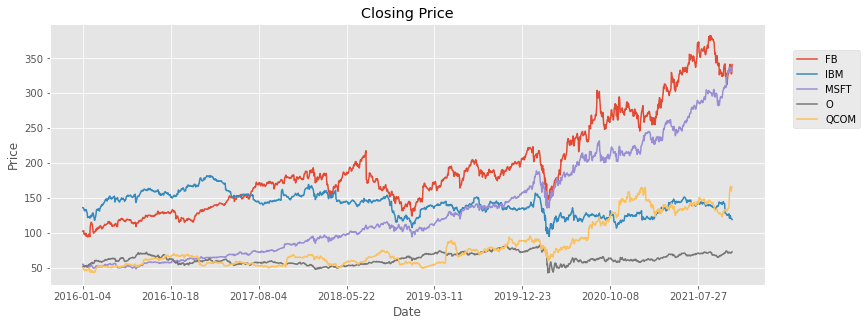

In [5]:
# plot some stock's closing price.
style.use("ggplot")

df.plot(figsize=(12.8, 4.8))
        
plt.title("Closing Price")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc=(1.04, 0.6))
plt.show()

### Calculation of the return and risk of a portfolio
- Calculate the annualised return by daily return multiplied by 252 (approximate number of trading days)
- Calculate the annualised risk using standard deviation

In [6]:
# define a function to return the risk and return of a portfolio
def riskreward(data, weight, date, lookbackperiod=756, avgtradingdays=252):
    
    # normalise weight so it will sum to 1
    weight = weight / np.sum(weight)
    
    # return
    data = data[:date][-lookbackperiod:] # slice records for calulcation
    
    daily_return_bystock = data.pct_change()
    
    mean_daily_return_bystock = daily_return_bystock.mean()

    mean_daily_return_portfolio = np.sum(mean_daily_return_bystock*weight)
    
    annualised_return = mean_daily_return_portfolio*avgtradingdays

    
    # risk
    # risk is measured by the standard deviation of the daily changes
    # to obtain standard deviation, we need to work out the variance
    # to obtain variance for a list of stocks, we use the weighted covraiance of the list of stocks
    covariance_portfolio = np.cov(daily_return_bystock[1:], rowvar = False)*avgtradingdays # skip first record as they are NaN

    variance_portfolio = np.dot(np.array(weight).T, np.dot(covariance_portfolio, weight))

    risk_portfolio = np.sqrt(variance_portfolio)
    
    
    # return the portfolio's return and risk for a given list and their weights
    return annualised_return, risk_portfolio


### Efficiency Frontier

In [7]:
# define a function generate different weights in the portfolio and return the portfolio's returns and risks
# this will be used to plot the efficiency frontier

def risk_return_many(data, num, date, lookbackperiod, avgtradingdays):

    tmplist = []
    weightlist = []
    for i in range(num):
        weight = np.random.random_sample(len(stocks))
        weight = weight / np.sum(weight)

        tmplist.append(riskreward(data, weight, date, lookbackperiod, avgtradingdays))
        tmplist2 = pd.DataFrame(tmplist, columns=['return','risk'])

        weightlist.append(weight)
        weightlist2 = pd.DataFrame(weightlist, columns=stocks)

    return tmplist2.merge(weightlist2, left_index=True, right_index=True)

## Main Steps
1. Download stock data for the portfolio if have not done so
2. Build the stocks' close prices into a dataframe
3. Calculate the returns and risks for the portfolio for many combination
4. Plot the Efficiency Frontier
5. Lastly, print out the weights for highest return and lowest risk.

In [8]:
# Step 1
# can only download 5 items per request so split list into two
# stocks = ["FB", "AAPL", "AMZN", "IBM", "GOOGL"]
# stocks = ["MSFT", "NVDA", "O", "QCOM", "TSLA"]

# download_stock_prices(stocks) # skip as already downloaded

In [9]:
# Step 2 - return a df of stock close price
stocks = ["FB", "AAPL", "AMZN", "IBM", "GOOGL", "MSFT", "NVDA", "O", "QCOM", "TSLA"]
start_date = "2000-01-01"
end_date = "2021-11-12" # <<<--- Set to latest date
data = stock_closeprice(stocks, start_date, end_date)
data.head()

,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
2012-05-18,38.2318,530.38,213.85,195.88,600.40,29.27,12.08,38.02,55.98,27.56
2012-05-21,34.0300,561.28,218.11,197.76,614.11,29.75,12.29,38.42,57.22,28.77
2012-05-22,31.0000,556.97,215.33,196.82,600.80,29.76,12.14,38.73,57.93,30.79
2012-05-23,32.0000,570.56,217.28,196.12,609.46,29.11,12.44,38.63,58.14,31.02
2012-05-24,33.0300,565.32,215.24,196.09,603.66,29.07,12.11,38.73,57.15,30.32


In [10]:
# Step 3 - return a df of return, risk and corresponding weights
lookbackperiod = 756
avgtradingdays = 252
df = risk_return_many(data, 3000, end_date, lookbackperiod, avgtradingdays)
df.head()

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
0,0.399776,0.359923,0.017315,0.223482,0.006481,0.119402,0.231367,0.007023,0.040485,0.008230,0.153722,0.192494
1,0.362673,0.311342,0.092300,0.158998,0.200146,0.057459,0.171136,0.012955,0.113020,0.025319,0.090302,0.078366
2,0.371009,0.291946,0.118616,0.053977,0.069961,0.005509,0.153632,0.155373,0.111738,0.158281,0.126152,0.046762
3,0.360387,0.296621,0.062761,0.029224,0.055799,0.103138,0.125976,0.091760,0.151209,0.153053,0.155680,0.071399
4,0.379798,0.313302,0.034308,0.050319,0.153484,0.126314,0.110618,0.024826,0.154195,0.100371,0.104148,0.141418


In [11]:
# Step 4 - Plot the efficiency frontier
df.iplot(kind='scatter', x = 'risk', y = 'return', mode='markers', size=5, color='blue')

In [12]:
# Step 5 - print out weights for highest return
df.loc[df[['return']].idxmax()]

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
532,0.492133,0.341723,0.169822,0.015599,0.007312,0.008241,0.216541,0.077471,0.046747,0.014228,0.233848,0.210192


In [13]:
# Step 5 - print out weights for lowest risk
df.loc[df[['risk']].idxmin()]

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
1741,0.279463,0.252242,0.047077,0.049038,0.2136,0.153534,0.163139,0.127794,0.013483,0.152616,0.07587,0.00385


## Comparison of Efficiency Frontier between pre-Covid (end 2019) and now.
The earlier run shows the efficiency frontier for the list of stocks as of now.
It will be of interest to examine how the efficiency frontier has shifted since pre-Covid.  So we rerun the function to examine the Efficieny Frontier pre-covid.

We will plot both the frontiers at the end to visualise how it has shifted.

In [14]:
# Step 2 - return a df of stock close price
stocks = ["FB", "AAPL", "AMZN", "IBM", "GOOGL", "MSFT", "NVDA", "O", "QCOM", "TSLA"]
start_date = "2000-01-01"
end_date = "2019-12-31" # <<<-------set end_date prior to Covid period
data2 = stock_closeprice(stocks, start_date, end_date)
data2.head()

,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
2012-05-18,38.2318,530.38,213.85,195.88,600.40,29.27,12.08,38.02,55.98,27.56
2012-05-21,34.0300,561.28,218.11,197.76,614.11,29.75,12.29,38.42,57.22,28.77
2012-05-22,31.0000,556.97,215.33,196.82,600.80,29.76,12.14,38.73,57.93,30.79
2012-05-23,32.0000,570.56,217.28,196.12,609.46,29.11,12.44,38.63,58.14,31.02
2012-05-24,33.0300,565.32,215.24,196.09,603.66,29.07,12.11,38.73,57.15,30.32


In [15]:
# Step 3 - return a df of return, risk and corresponding weights
lookbackperiod = 756
avgtradingdays = 252
df2 = risk_return_many(data2, 3000, end_date, lookbackperiod, avgtradingdays)
df2.head()

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
0,0.211596,0.185324,0.037249,0.057955,0.148071,0.131901,0.171942,0.084727,0.007096,0.086659,0.134747,0.139654
1,0.237572,0.198286,0.094584,0.123302,0.089098,0.127408,0.052099,0.153743,0.158642,0.062525,0.098216,0.040382
2,0.193648,0.173306,0.153992,0.009157,0.037336,0.114065,0.123572,0.154438,0.013433,0.132302,0.180700,0.081004
3,0.254052,0.208493,0.046950,0.120944,0.092843,0.112231,0.012824,0.164563,0.110346,0.046263,0.117190,0.175845
4,0.254540,0.192427,0.133255,0.079999,0.094161,0.027431,0.071100,0.156449,0.122799,0.150038,0.068405,0.096363


In [16]:
# Step 4 - Plot the efficiency frontier
df2.iplot(kind='scatter', x = 'risk', y = 'return', mode='markers', size=5, color='blue')

In [17]:
# Step 5 - print out weights for highest return
df2.loc[df2[['return']].idxmax()]

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
57,0.305893,0.224134,0.091069,0.239366,0.043728,0.007257,0.02781,0.239372,0.027425,0.033806,0.034912,0.255254


In [18]:
# Step 5 - print out weights for lowest risk
df2.loc[df2[['risk']].idxmin()]

,return,risk,FB,AAPL,AMZN,IBM,GOOGL,MSFT,NVDA,O,QCOM,TSLA
1188,0.183152,0.152154,0.030509,0.1033,0.174563,0.139688,0.06399,0.045977,0.058009,0.341735,0.037933,0.004295


## How the fund has performed since pre-Covid?
Presumbly a fund manager has rebalanced the portfolio pre-Covid (at end-2019), we can now examine how the portfolio fares as of now.
We assumed two scenarios:
1. He updated the weights to gives maximum return
2. He updated the weights to gives minimum risk

In [19]:
# extract weight from df2 (pre-Covid run) for max return and min risk
weights_max_return = df2.loc[df2[['return']].idxmax()].drop(['return', 'risk'], axis=1).values.flatten().tolist()
weights_min_risk = df2.loc[df2[['risk']].idxmin()].drop(['return', 'risk'], axis=1).T.values.flatten().tolist()

# calculate risk-return at end of 2019.
# Assuming he rebalanced the fund using the efficiency frontier at that point in time. 
end_date = "2019-12-31"
max_return_orginial = riskreward(data2, weights_max_return, end_date, lookbackperiod=756, avgtradingdays=252)
min_risk_orginial = riskreward(data2, weights_min_risk, end_date, lookbackperiod=756, avgtradingdays=252)

# calculate risk-return as of now.
end_date = "2021-11-12"
max_return_existing = riskreward(data, weights_max_return, end_date, lookbackperiod=756, avgtradingdays=252)
min_risk_existing = riskreward(data, weights_min_risk, end_date, lookbackperiod=756, avgtradingdays=252)


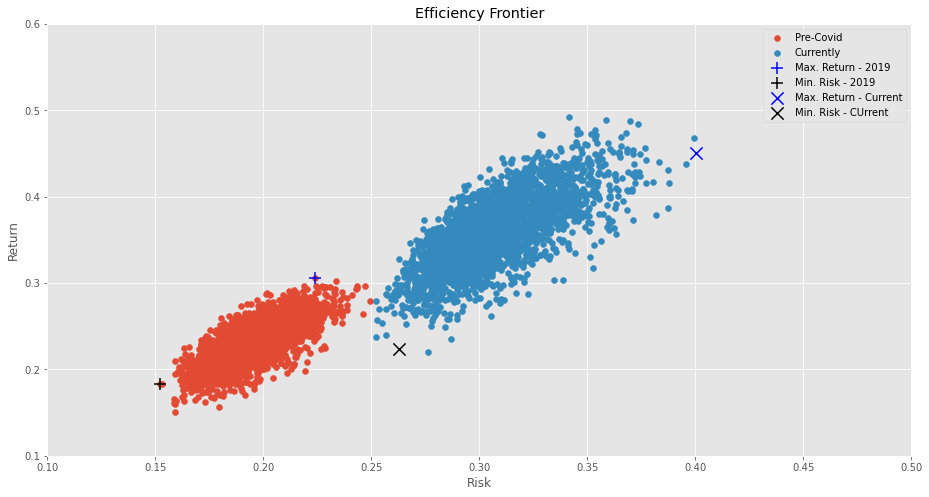

In [20]:
# combine all info into a single plot 
fig = plt.figure()

ax = fig.add_axes([1, 0.2, 2.0, 1.5])

# plot both efficiency frontier - pre-Covid and now
ax.scatter(df2['risk'], df2['return'], label='Pre-Covid')
ax.scatter(df['risk'], df['return'], label='Currently')

# plot fund manager risk-return for scenario 1 and 2 while rebalanced in 2019
ax.scatter(max_return_orginial[1], max_return_orginial[0], label='Max. Return - 2019', marker='+', s=150, c='blue')
ax.scatter(min_risk_orginial[1], min_risk_orginial[0], label='Min. Risk - 2019', marker='+', s=150, c='black')

# plot fund manager risk-return for scenario 1 and 2 as of now
ax.scatter(max_return_existing[1], max_return_existing[0], label='Max. Return - Current', marker='x', s=150, c='blue')
ax.scatter(min_risk_existing[1], min_risk_existing[0], label='Min. Risk - CUrrent', marker='x', s=150, c='black')

ax.set_title('Efficiency Frontier')
ax.set_xlabel('Risk')
ax.set_ylabel('Return')
ax.set_xlim(0.1, 0.5)
ax.set_ylim(0.1, 0.6)
ax.legend()

plt.show()

## Conclusions
- The Efficiency Frontier has shifted to the upper right area ie towards the right and upward. The rightward shift represented an increase in the volatility of the portfolio as its stocks experienced significant price shifts during the Covid period as expected. The upward shift corresponds to an increase in the return.


- The changes in the return are dependent on the list of stock in the portfolio.  In this case, they are all technology stock which has gained favour during the Covid period as more technology are adopted to adapt to the restricted phyiscal movement of people, goods and services.


- The portfolio has become less efficent with the passage of time. This is evidenced from the deviation of the black and blue 'plus' which lies initially along the efficiency frontier to an area below that of the new frontier line.


- Given that the new frontier shows (visually) an proportional increase in both risk and return, whether the new frontier is still as good as the previous frontier is subjective as the portfolio risk has increased significantly as well.


- Fund manager who adopted a maximum return might decide to lower the risk to adopt a new weights of existing stocks that is along the lower left of the frontier line to be more risk-adverse. However, this is just one of the many data and information that they considers in the management of their portfolio.